In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# YOLOv4 Object Detection on Webcam In Google Colab
This notebook will walkthrough all the steps for performing YOLOv4 object detections on your webcam while in Google Colab. We will be using scaled-YOLOv4 (yolov4-csp) for this tutorial, the fastest and most accurate object detector there currently is.

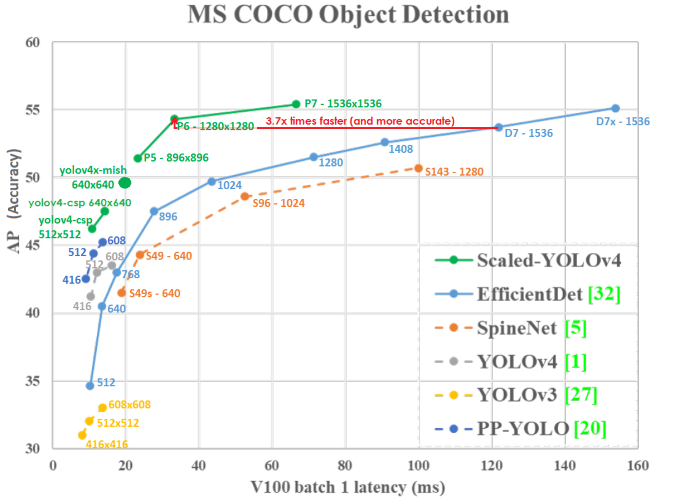

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
import sys
import os

py_file_location = "/content/drive/My Drive/car_detection"
sys.path.append(os.path.abspath(py_file_location))
import vehicles
%matplotlib inline

In [ ]:
def speedcal(dist,fps,temp,pxl):
  speed_m_s=fps*(dist/temp)
  speed_km_h=(speed_m_s*3600)/1000

  temp_err=pxl*(temp/fps)/(down_limit-up_limit)
 
  speed_m_s2=dist/((temp/fps)+temp_err)
  speed_km_h2=(speed_m_s2*3600)/1000


  val1=round(speed_km_h+abs(speed_km_h2-speed_km_h)/2,3)
  val2=round(abs(speed_km_h2-speed_km_h),3)
  return [val1,val2]


## Cloning and Setting Up Darknet for YOLOv4
We will be using the famous AlexeyAB's darknet repository in this tutorial to perform YOLOv4 detections.

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation. Feel free to checkout the darknet.py file to see the function definitions in detail! 

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## YOLOv4 Example on Test Image
Let's make sure our model has successfully been loaded and that we can make detections properly on a test image.

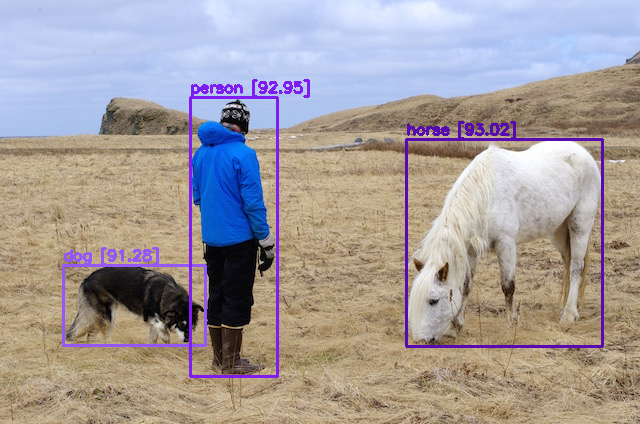

In [ ]:
# run test on person.jpg image that comes with repository
image = cv2.imread("data/person.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

## Helper Functions
Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4 on Wecam Images
Running YOLOv4 on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** which runs JavaScript code to utilize your computer's webcam. The code snippet will take a webcam photo, which we will then pass into our YOLOv4 model for object detection.

Below is a function to take the webcam picture using JavaScript and then run YOLOv4 on it.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
from random import randint
import time

class Car(object):
    tracks=[]
    def __init__(self,i,xi,yi,max_age):
        self.i=i
        self.x=xi
        self.y=yi
        self.tracks=[]
        self.R=randint(0,255)
        self.G=randint(0,255)
        self.B=randint(0,255)
        self.done=False
        self.state='0'
        self.age=0
        self.timein=0
        self.timeout=0
        self.errin=0
        self.errout=0
        self.max_age=max_age
        self.dir=None


   

    def getRGB(self):  #For the RGB colour
        return (self.R,self.G,self.B)
    def getTracks(self):
        return self.tracks

    def getId(self): #For the ID
        return self.i

    def geterrin(self): #For the ID
        return self.errin
    def geterrout(self): #For the ID
        return self.errout

    def getState(self):
        return self.state

    def getDir(self):
        return self.dir

    def getX(self):  #for x coordinate
        return self.x

    def getY(self):  #for y coordinate
        return self.y

    def gettimein(self):  #for y coordinate
        return self.timein

    def gettimeout(self):  #for y coordinate
        return self.timeout


    def updateCoords(self, xn, yn):
        self.age = 0
        self.tracks.append([self.x, self.y])
        self.x = xn
        self.y = yn

    def setstate(self,st):
        self.state = st

    def settimein(self,tm):
        self.timein = tm

    def seterrin(self,tm):
        self.errin = tm

    def seterrout(self,tm):
        self.errout = tm

    def settimeout(self,tm):
        self.timeout=tm

    def setDone(self):
        self.done = True

    def timedOut(self):
        return self.done

    def going_UP(self, mid_start, mid_end):
        if len(self.tracks)>=2:
            if self.state=='0':
                if self.tracks[-1][1]<mid_end and self.tracks[-2][1]>=mid_end:
                    self.setstate('1')
                    self.dir='up'
                    return True
                else:
                    return False
            else:
                return False
        else:
            return False
    def going_DOWN(self, mid_start, mid_end,frame):
        if len(self.tracks)>=2:
            if self.state=='0':
                if self.tracks[-1][1]>mid_end and self.tracks[-2][1]<=mid_end and self.done==False:
                    self.setstate('1')
                    self.seterrin(self.tracks[-1][1]-mid_end)
                    self.settimein(frame)
                    print("car id= ",self.i,"  timein= ",self.timein)   
                    self.dir='down'
                    return True
                else:
                    return False
            else:
                return False
        else:
            return False


    def savetimeout(self,mid_start,mid_end,x,y,h,w,frame):
        if len(self.tracks)>=2:
            if self.state=='1':
                if self.tracks[-1][1]>mid_end and self.tracks[-2][1]<=mid_end:
                  self.settimeout(frame)
                  self.setstate('0')
                  self.seterrout(self.tracks[-1][1]-mid_end)
                  print("car id= ",self.i,"  timeout= ",self.timeout)
                  capture = img[y:y+h, x:x+w]
                  if self.gettimeout()-self.gettimein()!=0 :
                    speed=speedcal(12.192,30,self.gettimeout()-self.gettimein(),abs(self.geterrout()-self.geterrin()))
                    if speed[0]>max_speed:
                      cv2.imwrite('/content/drive/MyDrive/car_detection/car_capts/photo'+str(self.getId())+'.jpg', capture)
                      cv2.putText(img, "captured", (int(x+w/3),y), font, 0.5, (255, 255, 255), 2, cv2.LINE_AA) 
                      ch="vitesse="+ str(speed[0])+"+-"+str(speed[1])
                      list_vitesse[(x,int(y+h/2))]=[ch,20]
                      print("vitesse = ",speed[0],"  +-", speed[1]) 
                      print("image captured")              
               
    
    def age_one(self):
        self.age+=1
        if self.age>self.max_age:
            self.done=True
        return  True

#Class2

class MultiCar:
    def __init__(self,cars,xi,yi):
        self.cars=cars
        self.x=xi
        self.y=yi
        self.tracks=[]
        self.R=randint(0,255)
        self.G=randint(0,255)
        self.B=randint(0,255)
        self.done=False


In [ ]:
for k in range(1):
  cnt_up=0
  cnt_down=0

  cap=cv2.VideoCapture("/content/drive/MyDrive/car_detection/videos/video1.mp4")
  frames=[]
#Get width and height of video

  w=cap.get(3)
  h=cap.get(4)
  framew=cap.get(3)
  frameh=cap.get(4)
  frameArea=h*w
  areaTH=frameArea/500
  areaTH2=frameArea/400

  #Lines
  line_up=int(1*(w/2))
  line_down=int(4*(w/6))
  up_limit=int(2*(w/5))
  down_limit=int(7*(w/8))


  print("Red line y:",str(line_down))
  print("Blue line y:",str(line_up))
  line_down_color=(255,0,0)
  line_up_color=(255,0,255)
  pt1 =  [0, line_down]
  pt2 =  [w, line_down]
  pts_L1 = np.array([pt1,pt2], np.int32)
  pts_L1 = pts_L1.reshape((-1,1,2))
  pt3 =  [0, line_up]
  pt4 =  [w, line_up]
  pts_L2 = np.array([pt3,pt4], np.int32)
  pts_L2 = pts_L2.reshape((-1,1,2))

  
  pt5 =  [0, up_limit]
  pt6 =  [w, up_limit]
  pts_L3 = np.array([pt5,pt6], np.int32)
  pts_L3 = pts_L3.reshape((-1,1,2))
  pt7 =  [0, down_limit]
  pt8 =  [w, down_limit]
  pts_L4 = np.array([pt7,pt8], np.int32)
  pts_L4 = pts_L4.reshape((-1,1,2))

  font = cv2.FONT_HERSHEY_SIMPLEX
  cars = []
  max_p_age = 5
  pid = 1
  total=0




  
  max_speed=75
  list_vitesse={}




  print("begin")
  while(cap.isOpened()):
    ret,img=cap.read()
    print("processing img "+str(len(frames)))
    img=img_rotate_90_clockwise = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    for i in cars:
        i.age_one()
    
    height,width,_=img.shape
    #print(img.shape)
    if ret==True:
      height,width,_=img.shape
      detections, width_ratio, height_ratio = darknet_helper(img,   height,width)

      # loop through detections and draw them on webcam image
      for label, confidence, bbox in detections:
        
        left, top, right, bottom = bbox2points(bbox)
        left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)

        x,y,w,h=left,top,right-left,bottom-top
        if x==-1:
          x=0
        if y==-1:
          y=0
        #print(x,y)
        cx=int(x+w/2)
        cy=int(y+h/2)
        new=True
        if cy in range(up_limit,down_limit):
          #print(len(cars))
          for i in cars:
           
              if abs(x - i.getX()) <= w and abs(y - i.getY()) <= h  :
                print(i.getId())
                new = False
                i.updateCoords(cx, cy)
                # if i.going_UP(line_up,line_down)==True:
                #   cnt_up+=1
                #   #print("ID:",i.getId(),'crossed going up at', time.strftime("%c"))
                if i.going_DOWN(line_down,line_up,len(frames))==True:
                  cnt_down+=1
                  #print("ID:", i.getId(), 'crossed going down at', time.strftime("%c"))
                  #i.settimein("time")
                  #print("car id= ", i.getId(),"  timein= ",i.gettimein())   
                
                i.savetimeout(line_up,line_down,x,y,h,w,len(frames))            
                if i.getState()=='0':
                  if i.getDir()=='down'and i.getY()>=line_down:
                    i.setDone()
               
                if len(i.getTracks())>=2:
                  if (i.getTracks()[-1][1]>up_limit and i.getTracks()[-2][1]<=up_limit)or i.timedOut() :
                    index=cars.index(i)
                    cars.pop(index)
                    del i
                break
          if new==True: #If nothing is detected,create new

            p=Car(pid,cx,cy,max_p_age)
            cars.append(p)
            pid+=1
            total= total+1


      
        cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
        cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                          (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                          class_colors[label], 2)
        
        #if height>y+h>height-400:
          #capture = img[y:y+h, x:x+w]
          #cv2.imwrite('/content/drive/MyDrive/car_detection/car_capts/photo'+str(total)+'.jpg', capture)
          #total= total+1
          #print("captured")
          
      # save image
      for i in cars:
        
        cv2.putText(img, str(i.getId()), (i.getX(), i.getY()), font, 0.3, i.getRGB(), 1, cv2.LINE_AA)
      
      cv2.putText(img,"car nbr = " +str(cnt_down), (int(framew/10), int(frameh/10)), font, 1, (255,0,0), 1, cv2.LINE_AA)

      if len(list_vitesse)>0:
        for i in list_vitesse.keys():
          if list_vitesse[i][1]!=0:
            cv2.putText(img, list_vitesse[i][0], (i[0],i[1]-40), font, 0.5, (255, 255, 255), 2, cv2.LINE_AA) 
            list_vitesse[i][1]=list_vitesse[i][1]-1
      img=cv2.polylines(img,[pts_L1],False,line_down_color,thickness=3)
      img=cv2.polylines(img,[pts_L2],False,line_up_color,thickness=3)
      img=cv2.polylines(img,[pts_L3],False,(255,255,255),thickness=1)
      img=cv2.polylines(img,[pts_L4],False,(255,255,255),thickness=1)
      cv2.imwrite('/content/drive/MyDrive/car_detection/captures/image'+str(len(frames))+'.png',img)
      #print(height)
      frames.append(img)
      
    else:
          break
  cap.release()
  print("cnt_up ",cnt_up)
  print("cnt_down ",cnt_down)
  print("end processing images",len(frames))
  # print("start creating the video ")
  # height,width,_= frames[0].shape
  # out = cv2.VideoWriter('/content/drive/MyDrive/car_detection/project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
  # for image in frames:
  #     video.write(image)

  # video.release()

  # # Show the image which was just taken.
  # print('done')


Red line y: 1280
Blue line y: 960
begin
processing img 0
processing img 1
processing img 2
processing img 3
processing img 4
processing img 5
processing img 6
processing img 7
processing img 8
processing img 9
processing img 10
processing img 11
processing img 12
processing img 13
processing img 14
processing img 15
processing img 16
processing img 17
processing img 18
processing img 19
processing img 20
processing img 21
processing img 22
processing img 23
processing img 24
processing img 25
processing img 26
processing img 27
processing img 28
processing img 29
processing img 30
processing img 31
processing img 32
processing img 33
processing img 34
processing img 35
processing img 36
processing img 37
processing img 38
processing img 39
processing img 40
processing img 41
processing img 42
processing img 43
processing img 44
processing img 45
processing img 46
processing img 47
processing img 48
1
2
processing img 49
2
processing img 50
2
processing img 51
2
processing img 52
2
proc

In [ ]:
print(list_vitesse)

{(241, 1169): ['vitesse=82.654+-0.716', 10]}


In [ ]:
print("cnt_up ",cnt_up)
print("cnt_down ",cnt_down)

cnt_up  0
cnt_down  20


Creer u video a partir des captures


In [ ]:
liste_im=os.listdir("/content/drive/MyDrive/car_detection/captures")
print(len(liste_im))
out = cv2.VideoWriter('/content/drive/MyDrive/car_detection/project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20, (1080,1920))
for i in range(0,len(liste_im)):
  img=cv2.imread('/content/drive/MyDrive/car_detection/captures/image'+str(i)+'.png')
  print("reading image "+str(i))
  out.write(img)
  #capt = plt.imshow(image)
  #plt.show(capt)
  #cv2.destroyAllWindows()
out.release()
cv2.destroyAllWindows()

889
reading image 0
reading image 1
reading image 2
reading image 3
reading image 4
reading image 5
reading image 6
reading image 7
reading image 8
reading image 9
reading image 10
reading image 11
reading image 12
reading image 13
reading image 14
reading image 15
reading image 16
reading image 17
reading image 18
reading image 19
reading image 20
reading image 21
reading image 22
reading image 23
reading image 24
reading image 25
reading image 26
reading image 27
reading image 28
reading image 29
reading image 30
reading image 31
reading image 32
reading image 33
reading image 34
reading image 35
reading image 36
reading image 37
reading image 38
reading image 39
reading image 40
reading image 41
reading image 42
reading image 43
reading image 44
reading image 45
reading image 46
reading image 47
reading image 48
reading image 49
reading image 50
reading image 51
reading image 52
reading image 53
reading image 54
reading image 55
reading image 56
reading image 57
reading image 58
rea